In [1]:
# ONA for Python - Noise reduction in Black Carbon data | version 01 (May 2020)

# ONA is the Optimized Noise reduction Averaging (ONA) algorithm developed by Hagler et al. (2011) to reduce the occurence
# negative values of BC data while preserving the significant dynamics trends in the time series. More information about ONA can be found in:

# Hagler GSW, Yelverton TLB, Vedantham R, Hansen ADA, Turner JR (2011) Post-processing Method to Reduce Noise while Preserving High Time Resolution
# in Aethalometer Real-time Black Carbon Data. Aerosol and Air Quality Research 11, 539–546. doi: 10.4209/aaqr.2011.05.0055

# The original algorithm was developed in MatLab code and this script aims to implement in Python code

In [2]:
# This program will look for positive (and final) changes in ATN throughout the data. This code
# anticipates that a variable named “BC_ONA” has already been created and has the following
# columns – 1) serial timestamp, 2) original BC concentrations, and 3) original ATN values.

In [4]:
# The example used in this code is regarding BC data obtained by a microAeth® AE51 (from ARTHLABS) 
# in a monitoring campaign in Greeland.

In [5]:
import numpy as np

In [6]:
import matplotlib.pyplot as plot

In [7]:
import csv

In [8]:
import time

In [9]:
import pandas as pd

In [10]:
# Check your working folder by using "pwd" and then "cd 'path'" to enter in the desired folder

In [11]:
pwd

'C:\\Users\\Nuno Canha\\Desktop\\Python\\Geo\\Notebooks'

In [12]:
cd C:\Users\Nuno Canha\Desktop\Python\BC\Test01

C:\Users\Nuno Canha\Desktop\Python\BC\Test01


In [13]:
pwd

'C:\\Users\\Nuno Canha\\Desktop\\Python\\BC\\Test01'

In [88]:
# Preparing data

fields = [] 
rows = [] 

In [89]:
with open('2017_BC_ONA_966.csv') as f:
    csvreader = csv.reader(f) 
    fields = next(csvreader)
    # extracting each data row one by one 
    for row in csvreader: 
        rows.append(row)

In [90]:
data = np.array(rows)
b= []
data_times =[]
for i in range(len(data[:,0])):
    a=pd.to_datetime(data[i,0])
    b.append(a)
    
    # Time as posix
    data_times.append(time.mktime(a.timetuple()))

In [91]:
# First column is datetime:
data_times = np.array(data_times)

# Second column is black carbon data (BC):
bc = data[:,1]

# Third column is attenuation data (atn):
atn = data[:,2]

# Create three column BC_ONA matrix: 
BC_ONA = np.array([data_times,bc,atn])
BC_ONA = BC_ONA.transpose()

In [92]:
# Create new variable
BC_ONA_ATN=BC_ONA

In [104]:
# Find filter change points
temp = np.zeros([len(BC_ONA)-1,1])
for i in range(len(BC_ONA)-1):
    temp[i,0] = abs(float(BC_ONA_ATN[i+1,2])-float(BC_ONA_ATN[i,2]))
temp1= np.array(np.where(temp[:,0]>30))
if temp1.size == 0 :
    filtchange = np.array([0])
    filtchange = np.append(filtchange,len(BC_ONA_ATN))
else:
    filtchange = np.array([[0],[len(BC_ONA_ATN)]])
del i,temp1

In [105]:
# Check the new variable "temp" that contains the ATN changes between BC measures
temp

array([[0.001],
       [0.001],
       [0.002],
       ...,
       [0.001],
       [0.004],
       [0.001]])

In [95]:
len(temp)

10602

In [107]:
len(BC_ONA_ATN)

2

In [97]:
# Define the ATN default incremental value
delATN=0.05

In [98]:
# Calculate smoothed BC
temp = np.zeros([len(BC_ONA_ATN),4])
temp[:,:-1] = BC_ONA_ATN
BC_ONA_ATN = temp
del temp
BC_ONA_ATN[:,3] = 1
temp = np.array([])
for i in range(len(BC_ONA_ATN[:,2])):
    if BC_ONA_ATN[i,2] != '-':
        temp2 = float(BC_ONA[i,2]) 
        temp = np.append(temp,temp2)  
        del temp2
for k in range(len(filtchange)-1):
    j = filtchange[k] #set to first point after filter change
    j = int(j)
    for i in range(j,len(BC_ONA_ATN)):
        if j<filtchange[k+1]:
            if i==j:
                des_ind =np.where(temp[j+1:len(BC_ONA_ATN)]<=(temp[j]+delATN))
                temp2 = des_ind[-1]
                # des_ind = des_ind[-1]
                # if len(des_ind) == 0:
                if len(temp2) != 0:
                    
                    # Calculated smoothed new BC
                    BC_ONA_ATN[j:temp2[-1]+j,1]=np.nanmean(BC_ONA_ATN[j:temp2[-1]+j,1])
                    
                    # Calculate averaging period
                    BC_ONA_ATN[j:temp2[-1]+j+1,3]=len(BC_ONA_ATN[j:temp2[-1]+j,1])
                    j = j+temp2[-1]+1
                else:
                    j = j+1
del filtchange

In [99]:
# The variable "BC_ONA_ATN" contains now 4 different collumns: "Time" (as posix), "Corrected BC", "ATN" and "points average"
BC_ONA_ATN

array([[ 1.49677668e+09,  2.27875000e+01,  4.58900000e+00,
         8.00000000e+01],
       [ 1.49677674e+09,  2.27875000e+01,  4.59000000e+00,
         8.00000000e+01],
       [ 1.49677680e+09,  2.27875000e+01,  4.59100000e+00,
         8.00000000e+01],
       ...,
       [ 1.49875920e+09,  3.13333333e+01,  1.19500000e+01,
         6.00000000e+00],
       [ 1.49875950e+09,  3.10000000e+01,  1.19540000e+01,
         6.00000000e+00],
       [ 1.49875980e+09, -6.00000000e+00,  1.19530000e+01,
         1.00000000e+00]])

In [100]:
# METRICS OF SMOOTHING PERFORMANCE 
# The code from this point forwards only displays the results and does not do any data alteration.

In [101]:
#1. Reduction of negatives - fraction in original vs. remaining
temp2 = 0
temp3 = 0

for i in range(len(BC_ONA[:,1])):
    if BC_ONA_ATN[i,1] != '':
        if float(BC_ONA[i,1])<0:
            temp2 += 1
    if BC_ONA_ATN[i,1] != '-':
            if float(BC_ONA_ATN[i,1])<0:
             temp3 += 1     

numneg_org=temp2/len(BC_ONA[:,1])
numneg_filt=temp3/len(BC_ONA[:,1])
del temp2,temp3
print("Fraction of negative values in original dataset = ",numneg_org)
print("Fraction of negative values after ONA correction = ",numneg_filt)
del numneg_org,numneg_filt

Fraction of negative values in original dataset =  0.30104687352636045
Fraction of negative values after ONA correction =  0.0019805715363576345


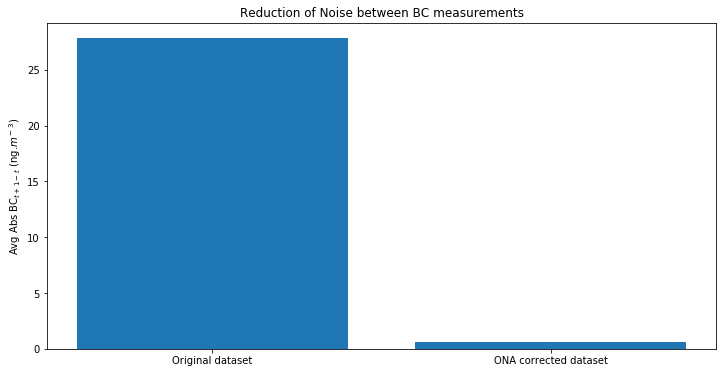

In [109]:
#2. Reduction of noise

temp = np.zeros([len(BC_ONA)-1,2])
for i in range(len(BC_ONA)-1):
    if BC_ONA_ATN[i,1] != '' and BC_ONA_ATN[i+1,1] != '':
        temp[i,0]=abs(float(BC_ONA[i+1,1])-float(BC_ONA[i,1]))
    if BC_ONA_ATN[i,1] != '-' and BC_ONA_ATN[i+1,1] != '-':
        temp[i,1]=abs(float(BC_ONA_ATN[i+1,1])-float(BC_ONA_ATN[i,1]))

noise = np.array([np.nanmean(temp[:,0]),np.nanmean(temp[:,1])])
langs = ['Original dataset','ONA corrected dataset']
fig = plot.figure()
plot.bar(langs,noise)
plot.title ('Reduction of Noise between BC measurements')
plot.ylabel('Avg Abs BC$_{t+1 - t}$ (ng.$m^-$$^3$)')
plot.rcParams['figure.figsize']=[12,6]
plot.savefig('Noise Reduction.png')

Text(0, 0.5, 'avg timebase (s)')

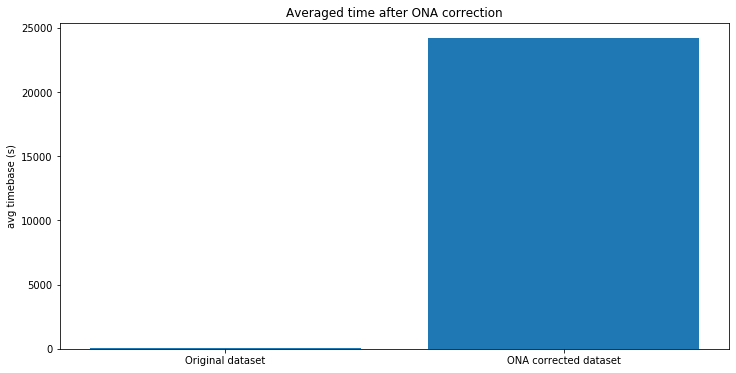

In [113]:
#3. Averaging interval and histogram of points averaged

time_inc = abs(float(BC_ONA[1,0])-float(BC_ONA[0,0]))
temp = BC_ONA_ATN[:,3].astype(np.float)
timeavg = np.array([time_inc,np.nanmean(temp)*time_inc])
fig2 = plot.figure()
plot.title ('Averaged time after ONA correction')
plot.bar(langs,timeavg)
plot.ylabel('avg timebase (s)')

Text(0, 0.5, 'N pts affected')

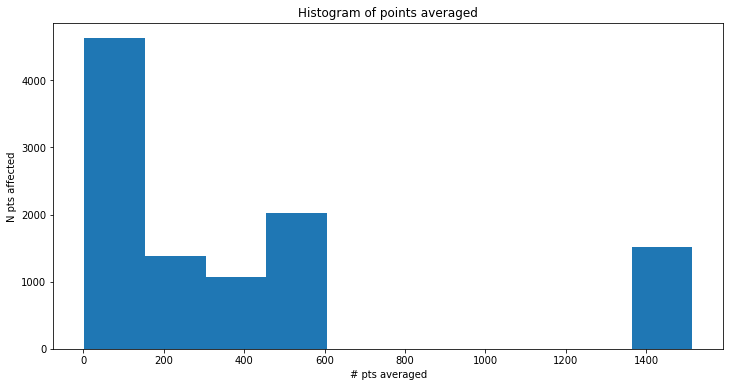

In [114]:
del time_inc,temp,timeavg
fig3 = plot.figure()
plot.hist(BC_ONA_ATN[:,3], bins = 10)
plot.title ('Histogram of points averaged')
plot.xlabel('# pts averaged')
plot.ylabel('N pts affected')

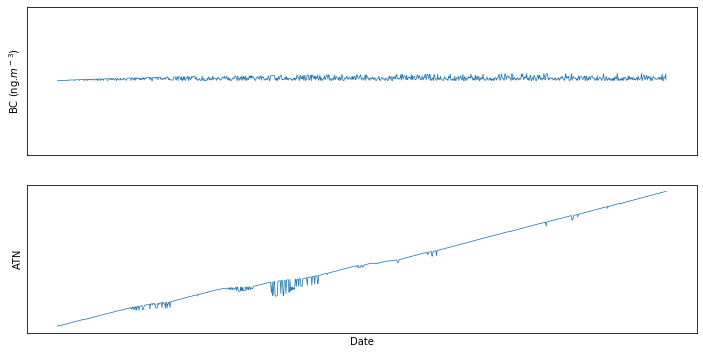

In [118]:
#4. Before - top figure BC time series, bottom figure ATN time series

fig4 = plot.figure()

# posix times and datetimes
plot.subplot(211)
yticks = [-2000,0,2000]
plot.plot(BC_ONA[::10,0], BC_ONA[::10,1],linewidth=0.75)
plot.yticks(yticks)
plot.ylabel('BC (ng.$m^-$$^3$)')
plot.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

# posix times:
plot.subplot(212)
plot.plot(BC_ONA[::10,0], BC_ONA[::10,2],linewidth=0.75)
plot.ylabel('ATN')
plot.xlabel('Date')
plot.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)


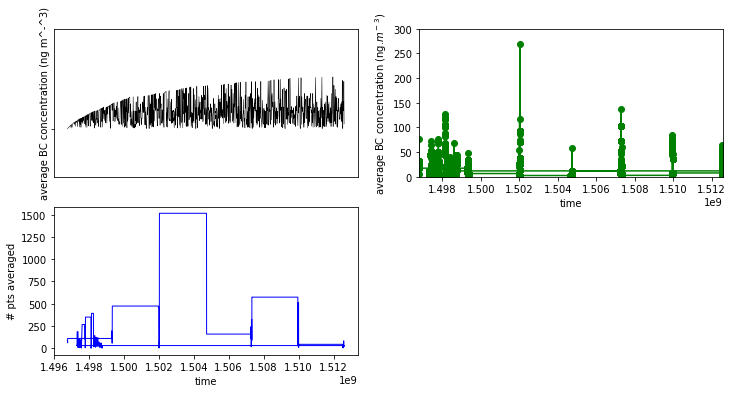

In [157]:
#5 After - top figure BC and BC-ONA time series, bottom figure averaging time
fig5 = plot.figure()
plot.subplot(221)
yticks = [-2000,0,2000]
plot.yticks(yticks)
plot.plot(BC_ONA[::10,0], BC_ONA[::10,1],color ='black',linewidth=0.5)
plot.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=True, labelleft=False)
plot.ylabel('average BC concentration (ng m^-^3)')
plot.axis('equal')
plot.subplot(222)

plot.plot(BC_ONA_ATN[:,0], BC_ONA_ATN[:,1],color ='green', marker='o')
plot.xlabel('time')
plot.axis([min(BC_ONA_ATN[:,0]), max(BC_ONA_ATN[:,0]),0,300])
plot.ylabel('average ONA BC concentration (ng.$m^-$$^3$)')

plot.subplot(223)
plot.plot(BC_ONA_ATN[:,0], BC_ONA_ATN[::,3],color ='blue',linewidth=1)
plot.xlabel('time')
plot.ylabel('# pts averaged')

plot.show()

In [194]:
# Conversion of Numpy array to Pandas dataframe of BC_ONA_ATN
BC_ONA_ATN

array([[ 1.49677668e+09,  2.27875000e+01,  4.58900000e+00,
         8.00000000e+01],
       [ 1.49677674e+09,  2.27875000e+01,  4.59000000e+00,
         8.00000000e+01],
       [ 1.49677680e+09,  2.27875000e+01,  4.59100000e+00,
         8.00000000e+01],
       ...,
       [ 1.49875920e+09,  3.13333333e+01,  1.19500000e+01,
         6.00000000e+00],
       [ 1.49875950e+09,  3.10000000e+01,  1.19540000e+01,
         6.00000000e+00],
       [ 1.49875980e+09, -6.00000000e+00,  1.19530000e+01,
         1.00000000e+00]])

In [195]:
Final_BC_ONA = pd.DataFrame({'Timestamp': BC_ONA_ATN[:,0],'BC ONA': BC_ONA_ATN[:,1],'ATN': BC_ONA_ATN[:,2],'Points average': BC_ONA_ATN[:,3],})

In [196]:
Final_BC_ONA

,Timestamp,BC ONA,ATN,Points average
0,1.496777e+09,22.787500,4.589,80.0
1,1.496777e+09,22.787500,4.590,80.0
2,1.496777e+09,22.787500,4.591,80.0
3,1.496777e+09,22.787500,4.593,80.0
4,1.496777e+09,22.787500,4.594,80.0
...,...,...,...,...
10598,1.498759e+09,31.333333,11.946,6.0
10599,1.498759e+09,31.333333,11.949,6.0
10600,1.498759e+09,31.333333,11.950,6.0
10601,1.498760e+09,31.000000,11.954,6.0


In [197]:
# Check the number of occurencies of negative concentrations of BC:

neg=Final_BC_ONA[['BC ONA']].agg(lambda x: sum(x < 0)).sum()

In [130]:
neg

21

In [131]:
# Total number of concentrations values available for BC:
total=len(Final_BC_ONA['BC ONA'])
print(total)

10603


In [132]:
# Calculate the percentage of BC negative values:
pneg = neg/total*100
print("The percentage of negative BC values in the dataset is", pneg.round(0).astype(int), "%." )

The percentage of negative BC values in the dataset is 0 %.


In [198]:
# Conversion of timestamp from Posix to Year-Month-Day Hour:Minute
Final_BC_ONA['Timestamp'] = pd.to_datetime(Final_BC_ONA['Timestamp'],unit='s')

In [199]:
Final_BC_ONA

,Timestamp,BC ONA,ATN,Points average
0,2017-06-06 19:18:00,22.787500,4.589,80.0
1,2017-06-06 19:19:00,22.787500,4.590,80.0
2,2017-06-06 19:20:00,22.787500,4.591,80.0
3,2017-06-06 19:21:00,22.787500,4.593,80.0
4,2017-06-06 19:22:00,22.787500,4.594,80.0
...,...,...,...,...
10598,2017-06-29 17:50:00,31.333333,11.946,6.0
10599,2017-06-29 17:55:00,31.333333,11.949,6.0
10600,2017-06-29 18:00:00,31.333333,11.950,6.0
10601,2017-06-29 18:05:00,31.000000,11.954,6.0


In [139]:
# To create a new dataframe called "plot_BC ONA" with only the columns "Timestamp" and "BC ONA":

plot_BC_ONA=Final_BC_ONA[['Timestamp','BC ONA']]

# To check if new dataframe is ok:
plot_BC_ONA.head()

,Timestamp,BC ONA
0,2017-06-06 19:18:00,22.7875
1,2017-06-06 19:19:00,22.7875
2,2017-06-06 19:20:00,22.7875
3,2017-06-06 19:21:00,22.7875
4,2017-06-06 19:22:00,22.7875


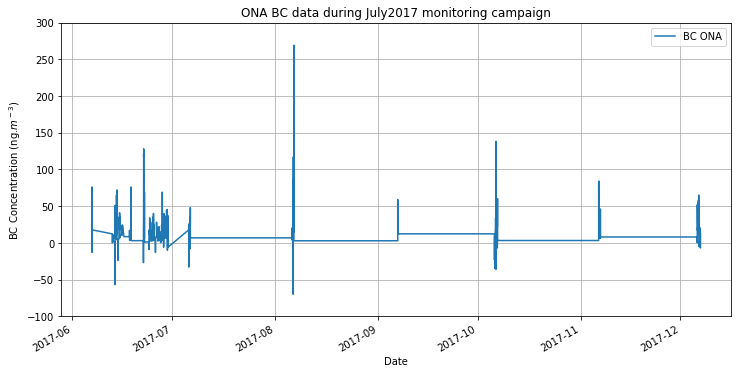

In [145]:
ax2 = plot_BC_ONA.plot('Timestamp', 'BC ONA', title = 'ONA BC data during July2017 monitoring campaign',
                   ylim=[-100,300])
ax2.set_xlabel('Date')
ax2.set_ylabel('BC Concentration (ng.$m^-$$^3$)')
ax2.grid(True)

In [158]:
# Histogram of ONA BC data
Hist_BC_ONA=Final_BC_ONA[['BC ONA']]

In [159]:
Hist_BC_ONA

,BC ONA
0,22.787500
1,22.787500
2,22.787500
3,22.787500
4,22.787500
...,...
10598,31.333333
10599,31.333333
10600,31.333333
10601,31.000000


Text(0.5, 0, 'BC Concentration (ng.$m^-$$^3$)')

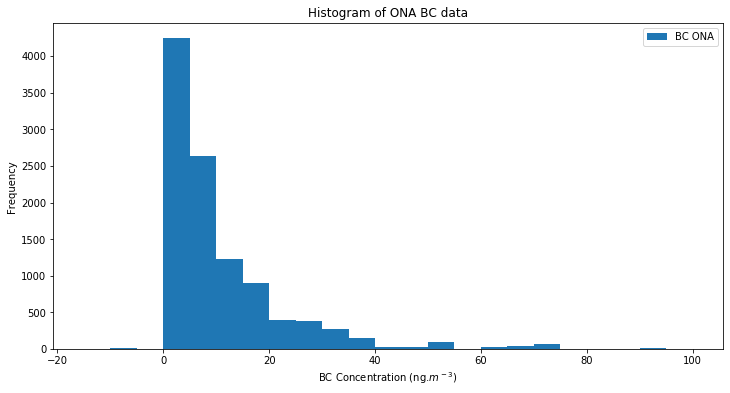

In [265]:
ax3 = Hist_BC_ONA.plot.hist(range=[-20, 100],bins=[-15,-10,-5, 0,5,10,15, 20,25, 30,35, 40,45, 50,55,60,65,70,75,80,85,90,95, 100], title = 'Histogram of ONA BC data')
ax3.set_xlabel('BC Concentration (ng.$m^-$$^3$)')

In [169]:
negHist=Hist_BC_ONA[['BC ONA']].agg(lambda x: sum(x < 0)).sum()

In [170]:
negHist

21

Text(0.5, 0, 'BC Concentration (ng.$m^-$$^3$)')

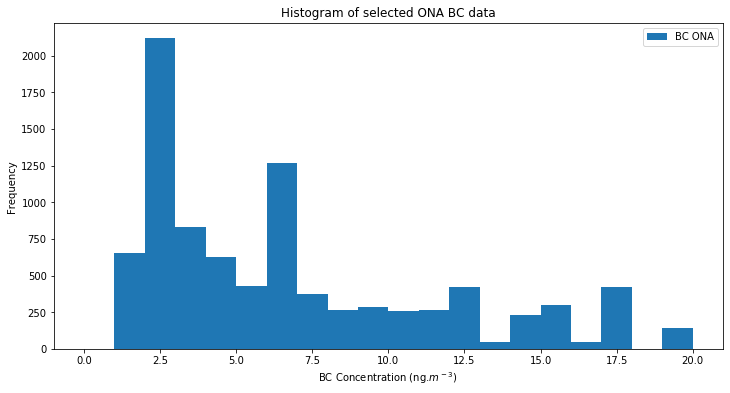

In [189]:
ax4 = Hist_BC_ONA.plot.hist(range=[0, 20], bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],title = 'Histogram of selected ONA BC data')
ax4.set_xlabel('BC Concentration (ng.$m^-$$^3$)')

In [191]:
# Goal: compare BC concentrations before and after ONA correction

# 1.Conversion of Numpy array to Pandas dataframe of BC_ONA
BC_ONA


array([['1496776680.0', '-12', '4.589'],
       ['1496776740.0', '12', '4.59'],
       ['1496776800.0', '60', '4.591'],
       ...,
       ['1498759200.0', '4', '11.95'],
       ['1498759500.0', '31', '11.954'],
       ['1498759800.0', '-6', '11.953']], dtype='<U32')

In [200]:
Initial_BC = pd.DataFrame({'Timestamp': BC_ONA[:,0],'BC': BC_ONA[:,1],'ATN': BC_ONA[:,2]})

In [201]:
Initial_BC

,Timestamp,BC,ATN
0,1496776680.0,-12,4.589
1,1496776740.0,12,4.59
2,1496776800.0,60,4.591
3,1496776860.0,66,4.593
4,1496776920.0,44,4.594
...,...,...,...
10598,1498758600.0,48,11.946
10599,1498758900.0,23,11.949
10600,1498759200.0,4,11.95
10601,1498759500.0,31,11.954


In [202]:
# 2. Conversion of timestamp from Posix to Year-Month-Day Hour:Minute
Initial_BC['Timestamp'] = pd.to_datetime(Initial_BC['Timestamp'],unit='s')

In [203]:
Initial_BC

,Timestamp,BC,ATN
0,2017-06-06 19:18:00,-12,4.589
1,2017-06-06 19:19:00,12,4.59
2,2017-06-06 19:20:00,60,4.591
3,2017-06-06 19:21:00,66,4.593
4,2017-06-06 19:22:00,44,4.594
...,...,...,...
10598,2017-06-29 17:50:00,48,11.946
10599,2017-06-29 17:55:00,23,11.949
10600,2017-06-29 18:00:00,4,11.95
10601,2017-06-29 18:05:00,31,11.954


In [236]:
# How to create a new dataframe (BC_ba: before and after) with only the timestamp, BC data before and after correction:

In [280]:
BC_ba = Initial_BC[['Timestamp']].join(Initial_BC[['BC']].join(Final_BC_ONA[['BC ONA']]))

In [281]:
BC_ba


,Timestamp,BC,BC ONA
0,2017-06-06 19:18:00,-12,22.787500
1,2017-06-06 19:19:00,12,22.787500
2,2017-06-06 19:20:00,60,22.787500
3,2017-06-06 19:21:00,66,22.787500
4,2017-06-06 19:22:00,44,22.787500
...,...,...,...
10598,2017-06-29 17:50:00,48,31.333333
10599,2017-06-29 17:55:00,23,31.333333
10600,2017-06-29 18:00:00,4,31.333333
10601,2017-06-29 18:05:00,31,31.000000


In [278]:
# Check if the data is in the correct format:

In [282]:
BC_ba.dtypes

Timestamp    datetime64[ns]
BC                   object
BC ONA              float64
dtype: object

In [283]:
# "BC" is not in the correct format (float) but it is in the object format. To change:

BC_ba["BC"] = BC_ba.BC.astype(float)

In [284]:
BC_ba.dtypes

Timestamp    datetime64[ns]
BC                  float64
BC ONA              float64
dtype: object

In [285]:
# How to do graphs about the BC concentrations before and after the ONA correction:

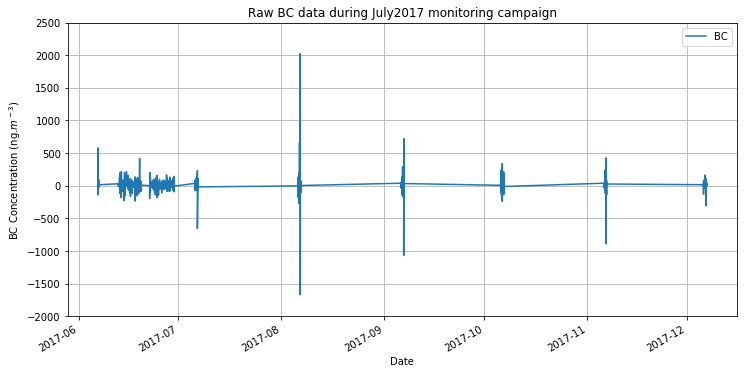

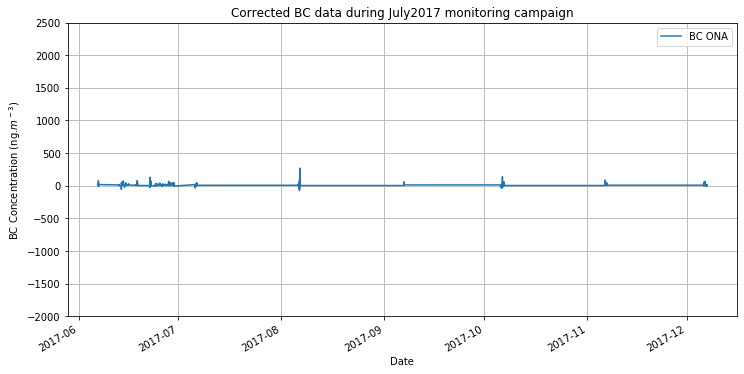

In [287]:
ax5 = BC_ba.plot('Timestamp', 'BC', title = 'Raw BC data during July2017 monitoring campaign',
                   ylim=[-2000,2500])
ax5.set_xlabel('Date')
ax5.set_ylabel('BC Concentration (ng.$m^-$$^3$)')
ax5.grid(True)

ax5 = BC_ba.plot('Timestamp', 'BC ONA', title = 'Corrected BC data during July2017 monitoring campaign',
                   ylim=[-2000,2500])
ax5.set_xlabel('Date')
ax5.set_ylabel('BC Concentration (ng.$m^-$$^3$)')
ax5.grid(True)